In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import json
import os
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
from sklearn import metrics
# import tqdm
from tqdm import tqdm
import torch
import copy
# import torch_directml
# import lightning as L

In [2]:
torch.version.cuda
print(torch.version.cuda)

None


### Feature extraction

In [3]:
file = open("config.json")
config = json.load(file)
# print(config.keys())
# print(config['data']['frame_size'])

fs = 44100              # Hz, sampling frequency
f_size = config['data']['frame_size']
h_size = config['data']['hop_size']
n_mel_channels = config['data']['n_mel_channels']

supra_frame_duration = 0.5  # seconds
supra_frame_length = round(supra_frame_duration / (h_size/fs)) # need to read from config.json / 

dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep
directory_ALS = os.listdir(dir_ALS)
directory_HC = os.listdir(dir_HC)

### Pre-analysis (transform wav-file to mel-spectrogramms)

In [5]:
X = np.zeros((20000,n_mel_channels, supra_frame_length))   # data
y = np.zeros((20000,1))                     # labels
X_global_index = 0
X_ids = list([])
# Cycle for HC (helthy controls)
for i in range(len(directory_HC)):    
    if directory_HC[i][-5:]=='a.wav':
        # print(directory_HC[i][-5:])
        fileName = dir_HC + directory_HC[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]    

        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_HC + directory_HC[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_HC[i][0:3]))
#             y[X_global_index] = 0
#             X_global_index = X_global_index +1
    
# Cycle for ALS (pathology)
for i in range(len(directory_ALS)):
    if directory_ALS[i][-5:]=='a.wav':
        fileName = dir_ALS + directory_ALS[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]
     
        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_ALS + directory_ALS[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_ALS[i][0:3]))
#             y[X_global_index] = 1
#             X_global_index = X_global_index + 1


### Dataset and Dataloader

In [4]:
class ALSDataset(Dataset):
    def __init__(self, dir_HC_path, dir_ALS_path):
        """
        Аргументы:
            dir_HC_path -- путь к папке с записями здоровых голосов
            dir_ALS_path -- путь к папке с записями голосов пациентов с БАС
        """
        # self.dir_HC_path = []
        # self.dir_ALS_path = []
        self._ids = list([])    # speaker IDs
        # 5-fold CV: 13+13+13+13+12
        # ALS: 8,20,21, 22, 24, 25,27,28,31,32,39, 42,46,48,52,55,58,62,64,68,72,76,78,80,84,92,94,96,98,100,102
        # HC : 131, 129, 127, 125, 123, 121, 119, 117, 115, 113, 111, 109, 107, 99, 97, 89, 86, 85, 81, 77, 65, 63, 61, 53, 49, 42, 28, 26, 24, 16, 6, 4, 2 
        
                                                                                        # HC men+women / ALS men+women
        self.folds = list(([26,   97, 117,  85,  53,  86, 127,  92, 102,  27,  32,  72,  39], # 3+4 HC / 3+3 ALS
                           [28,  123,  63,  99,  81, 125, 129,  68,  21,  55,  48,  78,  42], # 3+4 HC / 4+2 ALS
                           [61,   16, 115, 109, 111,   2, 107,  46,  84,  64,  52,  24,  76], # 2+5 HC / 4+2 ALS
                           [77,    6,  65,  24, 131, 119,  25,  94,  62,  28,   8,  98,  22], # 3+3 HC / 5+2 ALS
                           [49,   89,   4,  42, 113, 121,  96,  20,  58,  80,  31, 100]))     # 2+4 HC / 4+2 ALS
        
        self.folds_val = list(([49, 42, 20, 31],
                              [97, 53,  92, 32],
                              [28, 99, 129, 55],  
                              [61, 111, 84, 76],  
                              [77, 24, 94, 8]))
                              
        f_size = 512            # need to read from config.json
        h_size = 256            # need to read from config.json
        n_mel_channels = 64     # need to read from config.json
        supra_frame_length = 86 # need to read from config.json
        n_input_channel = 1        
        self.X = np.zeros((20000, n_input_channel, n_mel_channels, supra_frame_length))   # data
        self.y = np.zeros((20000,2))                         # labels
        X_global_index = 0
        self.X_ids = list([])

        # Cycle for HC (helthy controls)        
        directory_HC = os.listdir(dir_HC_path)       
        for i in range(len(directory_HC)):
            if directory_HC[i][-9:]=='a_mel.dat':
                fileName = dir_HC + directory_HC[i]
            
                X_spec = np.fromfile(dir_HC + directory_HC[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))        

                #Запись фрагметов спектра в трехмерный массив 
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:,:] = np.reshape(X_spec[:,n:n+supra_frame_length],(n_input_channel,n_mel_channels,supra_frame_length))
                    self.X_ids.append(int(directory_HC[i][0:3]))
                    self.y[X_global_index,:] = torch.nn.functional.one_hot(torch.tensor(0),num_classes=2)
                    X_global_index = X_global_index +1

        # Cycle for ALS (pathology)
        directory_ALS = os.listdir(dir_ALS_path)       
        for i in range(len(directory_ALS)):
            if directory_ALS[i][-9:]=='a_mel.dat':
                fileName = dir_ALS + directory_ALS[i]        

                # print(fileName)

                X_spec = np.fromfile(dir_ALS + directory_ALS[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))

        #       #Запись фрагметов спектра в трехмерный массив
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:,:] = np.reshape(X_spec[:,n:n+supra_frame_length],(n_input_channel,n_mel_channels,supra_frame_length))
                    self.X_ids.append(int(directory_ALS[i][0:3]))
                    self.y[X_global_index,:] = torch.nn.functional.one_hot(torch.tensor(1),num_classes=2)
                    X_global_index = X_global_index + 1
            
        inds_to_delete = np.array(range(self.y.shape[0]))>=X_global_index
        self.y = np.delete(self.y,inds_to_delete, axis=0)
        self.X = np.delete(self.X,inds_to_delete, axis=0)

        self.y = torch.from_numpy(self.y)
        self.X = torch.from_numpy(self.X)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.X = self.X.to(device)
        self.y = self.y.to(device)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index,:,:], self.y[index,:]

    def get_kth_fold_inds(self, fold_num):
        ids_train = list([])
        ids_val  = list([])
        ids_test = list([])
        for i in range(len(self.X_ids)):
            if self.X_ids[i] in self.folds[fold_num]:
                ids_test.append(i)
            elif self.X_ids[i] in self.folds_val[fold_num]:
                ids_val.append(i)
            else:
                ids_train.append(i)
        return (ids_train,ids_val, ids_test)

label =  1.0


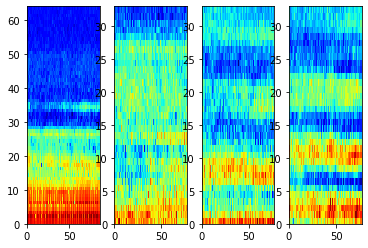

In [5]:
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
# print(len(DataSet_ALS))
X_generic, y_label = DataSet_ALS.__getitem__(13202)

fig,ax = plt.subplots()
plt.subplot(141)
plt.pcolor(X_generic[0,:,:], cmap='jet')
print('label = ', y_label)
fold_0_train,fold_0_val,fold_0_test = DataSet_ALS.get_kth_fold_inds(0)

## NN
conv_lf = torch.nn.Conv2d(1,3,(32,10),padding='valid',dtype=torch.float)

input = torch.tensor(X_generic,dtype=torch.float)
output = conv_lf(input)
output_np = output.detach().numpy()
plt.subplot(142)
plt.pcolor(output_np[0,:,:], cmap='jet')
plt.subplot(143)
plt.pcolor(output_np[1,:,:], cmap='jet')
plt.subplot(144)
plt.pcolor(output_np[2,:,:], cmap='jet')

#### CNN1-model

In [17]:
class ALS_CNN1(nn.Module):
    def __init__(self):
        super(ALS_CNN1,self).__init__() 
        # parameters
        # file = open("drive/MyDrive/Colab Notebooks/config.json")
        file = open("config.json")
        config = json.load(file)            
        self.n_mel = config['data']['n_mel_channels']
        frames_in_segment = config['data']['supra_frame_length']
        self.layer1_filt = 4
        
        self.lf_num = 32    # low-frequency
        self.mf_num = 16    # medium-frequency
        self.hf_num = 16    # high-frequency
        
        # low/medium/high-frequency frequency span
        # low/medium/high-frequency time span
        lf1_height, lf1_width = 29,43
        lf2_height, lf2_width = 7,15
        lf3_height, lf3_width = 3,7

        mf_height,mf_width = 13,27
        mf2_height,mf2_width = 15,43

        hf_height,hf_width = 3,3     
        hf2_height,hf2_width = 7,7
        hf3_height,hf3_width = 13,27
        hf4_height,hf4_width = 15,31

        mf_h_stride, hf_h_stride = 2,1
        mf_w_stride, hf_w_stride = mf_width//2, hf_width//2
        
        lf1_h_stride, lf1_w_stride = lf1_height//2, lf1_width//2
        lf2_h_stride, lf2_w_stride = lf2_height//2, lf2_width//2
        lf3_h_stride, lf3_w_stride = lf3_height//2, lf3_width//2

        mf2_h_stride, mf2_w_stride = hf_height//2, mf2_width//2

        hf2_h_stride, hf2_w_stride = hf2_height//2, hf2_width//2
        hf3_h_stride, hf3_w_stride = hf3_height//2, hf3_width//2
        hf4_h_stride, hf4_w_stride = hf4_height//2, hf4_width//2

        self.batch_norm1 = nn.BatchNorm2d(1)    # device='cuda'
        
        # self.conv_lf = torch.nn.Conv2d(1,self.layer1_filt,(self.lf_num, lf_width),padding='valid',stride=(1,lf_width//2))
        # self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(self.mf_num, mf_width),padding='valid',stride=(1,mf_width//2))
        # self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(self.hf_num, hf_width),padding='valid',stride=(1,hf_width//2))

        self.conv_lf1 = torch.nn.Conv2d(1,self.layer1_filt,(lf1_height, lf1_width),padding='valid',stride=(lf1_h_stride, lf1_w_stride))
        self.conv_lf2 = torch.nn.Conv2d(1,self.layer1_filt,(lf2_height, lf2_width),padding='valid',stride=(lf2_h_stride,lf2_w_stride))
        self.conv_lf3 = torch.nn.Conv2d(1,self.layer1_filt,(lf3_height, lf3_width),padding='valid',stride=(lf3_h_stride,lf3_w_stride))

        self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(mf_height, mf_width),padding='valid',stride=(mf_h_stride,mf_w_stride))
        self.conv_mf2= torch.nn.Conv2d(1,self.layer1_filt,(mf2_height, mf2_width),padding='valid',stride=(mf2_h_stride,mf2_w_stride))

        self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(hf_height, hf_width),padding='valid',stride=(hf_h_stride,hf_w_stride))
        self.conv_hf2 = torch.nn.Conv2d(1,self.layer1_filt,(hf2_height, hf2_width),padding='valid',stride=(hf2_h_stride,hf2_w_stride))
        self.conv_hf3 = torch.nn.Conv2d(1,self.layer1_filt,(hf3_height, hf3_width),padding='valid',stride=(hf3_h_stride,hf3_w_stride))
        self.conv_hf4 = torch.nn.Conv2d(1,self.layer1_filt,(hf4_height, hf4_width),padding='valid',stride=(hf4_h_stride,hf4_w_stride))

        max_pool_width = 1
        self.maxpool_lf1 = nn.MaxPool2d(((self.lf_num - lf1_height)//lf1_h_stride + 1,max_pool_width))        
        self.maxpool_lf2 = nn.MaxPool2d(((self.lf_num - lf2_height)//lf2_h_stride + 1,max_pool_width))
        self.maxpool_lf3 = nn.MaxPool2d(((self.lf_num - lf3_height)//lf3_h_stride + 1,max_pool_width))

        self.maxpool_mf = nn.MaxPool2d(((self.mf_num - mf_height)//mf_h_stride + 1,max_pool_width))
        self.maxpool_mf2= nn.MaxPool2d(((self.mf_num - mf2_height)//mf2_h_stride + 1,max_pool_width))

        self.maxpool_hf = nn.MaxPool2d(((self.hf_num - hf_height)//hf_h_stride + 1,max_pool_width))
        self.maxpool_hf2 = nn.MaxPool2d(((self.hf_num - hf2_height)//hf2_h_stride + 1,max_pool_width))
        self.maxpool_hf3 = nn.MaxPool2d(((self.hf_num - hf3_height)//hf3_h_stride + 1,max_pool_width))
        self.maxpool_hf4 = nn.MaxPool2d(((self.hf_num - hf4_height)//hf4_h_stride + 1,max_pool_width))

        self.drop1 = nn.Dropout(p=0.1)
        
        self.fc = nn.Linear(self.layer1_filt*((1+(frames_in_segment-lf1_width)//lf1_w_stride)//max_pool_width ) + # *(1+(self.lf_num-lf_height)//lf_height)
                            self.layer1_filt*((1+(frames_in_segment-lf2_width)//lf2_w_stride)//max_pool_width ) +
                            self.layer1_filt*((1+(frames_in_segment-lf3_width)//lf3_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-mf_width)//mf_w_stride)//max_pool_width) + #*(1+(self.mf_num-mf_height)//mf_height) + 
                            self.layer1_filt*((1+(frames_in_segment-mf2_width)//mf2_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-hf_width)//hf_w_stride)//max_pool_width) + #*(1+(self.hf_num-hf_height)//hf_height)
                            self.layer1_filt*((1+(frames_in_segment-hf2_width)//hf2_w_stride)//max_pool_width) + 
                            self.layer1_filt*((1+(frames_in_segment-hf3_width)//hf3_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-hf4_width)//hf4_w_stride)//max_pool_width)
                            ,2)                               

        torch.manual_seed(151)
        nn.init.xavier_uniform_(self.conv_lf1.weight)
        nn.init.xavier_uniform_(self.conv_lf2.weight)
        nn.init.xavier_uniform_(self.conv_lf3.weight)
        nn.init.xavier_uniform_(self.conv_mf.weight)
        nn.init.xavier_uniform_(self.conv_mf2.weight)
        nn.init.xavier_uniform_(self.conv_hf.weight)
        nn.init.xavier_uniform_(self.conv_hf2.weight)
        nn.init.xavier_uniform_(self.conv_hf3.weight)
        nn.init.xavier_uniform_(self.conv_hf4.weight)
        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x): 
        
        # print('x size', x.shape)
        out = self.batch_norm1(x)

        out1 = out[:,:,:self.lf_num,:]
        out2 = out[:,:,self.lf_num:self.lf_num+self.mf_num,:]
        out3 = out[:,:,self.lf_num+self.mf_num:self.lf_num+self.mf_num+self.hf_num,:]
        
        out_lf2 = out1.detach()
        out_lf3 = out1.detach()

        out_mf2 = out2.detach()
        
        out_hf2 = out3.detach()
        out_hf3 = out3.detach()
        out_hf4 = out3.detach()

        # for param in self.conv_lf.parameters():
        #     print(param.data)
        #     print(param.data.shape)
        # print(self.conv_lf.weight())        
        
        
        out1 = torch.nn.functional.elu(self.conv_lf1(out1))
        out_lf2 = torch.nn.functional.elu(self.conv_lf2(out_lf2))
        out_lf3 = torch.nn.functional.elu(self.conv_lf3(out_lf3))
        out2 = torch.nn.functional.elu(self.conv_mf(out2))
        out_mf2 = torch.nn.functional.elu(self.conv_mf2(out_mf2))
        out3 = torch.nn.functional.elu(self.conv_hf(out3))
        out_hf2 = torch.nn.functional.elu(self.conv_hf2(out_hf2))
        out_hf3 = torch.nn.functional.elu(self.conv_hf3(out_hf3))
        out_hf4 = torch.nn.functional.elu(self.conv_hf4(out_hf4))

        out1 = self.maxpool_lf1(out1)        
        out_lf2 = self.maxpool_lf2(out_lf2)
        out_lf3 = self.maxpool_lf3(out_lf3)

        out2 = self.maxpool_mf(out2)
        out_mf2 = self.maxpool_mf2(out_mf2)

        out3 = self.maxpool_hf(out3)
        out_hf2 = self.maxpool_hf2(out_hf2)
        out_hf3 = self.maxpool_hf3(out_hf3)
        out_hf4 = self.maxpool_hf4(out_hf4)

        out1 = out1.view(-1, out1.shape[1]*out1.shape[2]*out1.shape[3])
        out_lf2 = out_lf2.view(-1, out_lf2.shape[1]*out_lf2.shape[2]*out_lf2.shape[3])
        out_lf3 = out_lf3.view(-1, out_lf3.shape[1]*out_lf3.shape[2]*out_lf3.shape[3])
        out2 = out2.view(-1, out2.shape[1]*out2.shape[2]*out2.shape[3])
        out_mf2 = out_mf2.view(-1, out_mf2.shape[1]*out_mf2.shape[2]*out_mf2.shape[3])
        out3 = out3.view(-1, out3.shape[1]*out3.shape[2]*out3.shape[3])
        out_hf2 = out_hf2.view(-1, out_hf2.shape[1]*out_hf2.shape[2]*out_hf2.shape[3])
        out_hf3 = out_hf3.view(-1, out_hf3.shape[1]*out_hf3.shape[2]*out_hf3.shape[3])
        out_hf4 = out_hf4.view(-1, out_hf4.shape[1]*out_hf4.shape[2]*out_hf4.shape[3])

        out = torch.cat((out1, out_lf2, out_lf3, out2, out_mf2, out3, out_hf2, out_hf3, out_hf4), 1)  

        out = self.drop1(out)
        
        # print('fc.weight: ', self.fc.weight.shape)
        # print('out: ', out.shape)

        out = self.fc(out)
        return out  

#### CNN2-model

In [5]:
class ALS_CNN(nn.Module):
    def __init__(self):
        super(ALS_CNN,self).__init__() 
        # parameters
        file = open("drive/MyDrive/Colab Notebooks/config.json")
        config = json.load(file)            
        self.n_mel = config['data']['n_mel_channels']
        frames_in_segment = config['data']['supra_frame_length']
        layer1_filt = 18
        layer2_filt = 8
        
        self.lf_num = 32    # low-frequency
        self.mf_num = 16    # medium-frequency
        self.hf_num = 16    # high-frequency
        
        lf_width,  mf_width,  hf_width  = 48,36,16      # low/medium/high-frequency time span
        lf_height, mf_height, hf_height = 16,8,8      # low/medium/high-frequency frequency span

        l2_kernel_size = 5

        lf_h_stride, mf_h_stride, hf_h_stride = 2,1,1
        lf_w_stride, mf_w_stride, hf_w_stride = 4, 4, 4

        self.batch_norm1 = nn.BatchNorm2d(1)
        
        self.batch_norm_lf = nn.BatchNorm2d(layer1_filt)
        self.batch_norm_mf = nn.BatchNorm2d(layer1_filt)
        self.batch_norm_hf = nn.BatchNorm2d(layer1_filt)

        # self.conv_lf = torch.nn.Conv2d(1,self.layer1_filt,(self.lf_num, lf_width),padding='valid',stride=(1,lf_width//2))
        # self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(self.mf_num, mf_width),padding='valid',stride=(1,mf_width//2))
        # self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(self.hf_num, hf_width),padding='valid',stride=(1,hf_width//2))

        self.conv_lf = torch.nn.Conv2d(1,layer1_filt,(lf_height, lf_width),padding='valid',stride=(lf_h_stride,lf_w_stride))
        self.conv_mf = torch.nn.Conv2d(1,layer1_filt,(mf_height, mf_width),padding='valid',stride=(mf_h_stride,mf_w_stride))
        self.conv_hf = torch.nn.Conv2d(1,layer1_filt,(hf_height, hf_width),padding='valid',stride=(hf_h_stride,hf_w_stride))

        self.conv2_lf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))
        self.conv2_mf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))
        self.conv2_hf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))

        self.maxpool_lf = nn.MaxPool2d(((self.lf_num - lf_height)//lf_h_stride + 1 - (l2_kernel_size-1),1))
        self.maxpool_mf = nn.MaxPool2d(((self.mf_num - mf_height)//mf_h_stride + 1 - (l2_kernel_size-1),1))
        self.maxpool_hf = nn.MaxPool2d(((self.hf_num - hf_height)//hf_h_stride + 1 - (l2_kernel_size-1),1))

        self.drop1 = nn.Dropout(p=0.05)
        
        self.fc = nn.Linear(layer2_filt*(1+((frames_in_segment-lf_width)//lf_w_stride) - (l2_kernel_size-1)) + # *(1+(self.lf_num-lf_height)//lf_height)
                            layer2_filt*(1+((frames_in_segment-mf_width)//mf_w_stride) - (l2_kernel_size-1)) + #*(1+(self.mf_num-mf_height)//mf_height) + 
                            layer2_filt*(1+((frames_in_segment-hf_width)//hf_w_stride) - (l2_kernel_size-1)) #*(1+(self.hf_num-hf_height)//hf_height)
                            ,1)    # 16 = np.round(()/5).astype(int)                                  

        torch.manual_seed(151)
        # nn.init.xavier_uniform_(self.conv_lf.weight, gain=1.0)
        # nn.init.xavier_uniform_(self.conv_mf.weight, gain=1.0)
        # nn.init.xavier_uniform_(self.conv_hf.weight, gain=1.0)

        nn.init.kaiming_normal_(self.conv_lf.weight)
        nn.init.kaiming_normal_(self.conv_mf.weight)
        nn.init.kaiming_normal_(self.conv_hf.weight)

        nn.init.kaiming_normal_(self.conv2_lf.weight)
        nn.init.kaiming_normal_(self.conv2_mf.weight)
        nn.init.kaiming_normal_(self.conv2_hf.weight)

        nn.init.xavier_normal_(self.fc.weight)
    
    def forward(self, x): 
        
        out = self.batch_norm1(x)

        out1 = out[:,:,:self.lf_num,:]
        out2 = out[:,:,self.lf_num:self.lf_num+self.mf_num,:]
        out3 = out[:,:,self.lf_num+self.mf_num:self.lf_num+self.mf_num+self.hf_num,:]

        out1 = torch.relu(self.conv_lf(out1))
        out2 = torch.relu(self.conv_mf(out2))
        out3 = torch.relu(self.conv_hf(out3))
        
        out1 = self.batch_norm_lf(out1)
        out2 = self.batch_norm_mf(out2)
        out3 = self.batch_norm_hf(out3)

        out1 = torch.relu(self.conv2_lf(out1))
        out2 = torch.relu(self.conv2_mf(out2))
        out3 = torch.relu(self.conv2_hf(out3))

        out1 = self.maxpool_lf(out1)        
        out2 = self.maxpool_mf(out2)
        out3 = self.maxpool_hf(out3)

        out1 = out1.view(-1, out1.shape[1]*out1.shape[2]*out1.shape[3])
        out2 = out2.view(-1, out2.shape[1]*out2.shape[2]*out2.shape[3])
        out3 = out3.view(-1, out3.shape[1]*out3.shape[2]*out3.shape[3])

        # print('After view 1:', out1.shape)

        out = torch.cat((out1,out2,out3), 1)  

        # print('After cat:', out.shape)

        out = self.drop1(out)

        out = self.fc(out)
        return out

#### training_loop

In [6]:
def training_loop(n_epochs, optimizer, lr_scheduler, model, loss_fn, train_loader, val_loader):    
    MODEL_PATH = "model_backup/model_cnn.pt"
    loss_train_history = np.ndarray((n_epochs))
    loss_val_history = np.ndarray((n_epochs))
    lrs = []
    for epoch in range(1,n_epochs+1):        
        model.train()
        loss_val_best = 0
        loss_train = 0.0
        for specs, labels in tqdm(train_loader, desc=f"Epoch {epoch}", leave=True): #train_loader:
            specs = specs.float()
            outputs = model(specs)                        
            outputs = outputs.squeeze(dim=1) # for batch train_loader 
            # print('output:',outputs)
            # print('labels:',labels)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()            
        
        # prediction on val set        
        loss_val = 0.0
        TP_TN_sum = 0
        total = 0
        model.eval()
        with torch.no_grad():            
            for spec, label in val_loader:
                spec = spec.float()                    
                pred = model(spec)                                
                pred = torch.squeeze(pred,1)                

                loss = loss_fn(pred, label)
                loss_val += loss.item()

                _,pred = torch.max(pred, dim=1)
                _,label = torch.max(label, dim=1)
                        
                total += len(label)

                TP_TN_sum = TP_TN_sum + torch.sum(label==pred)

        acc_val = TP_TN_sum/total
        
        loss_train_history[epoch-1] = loss_train / len(train_loader)
        loss_val_history[epoch-1] = loss_val / len(val_loader)


        if loss_val > loss_val_best:
            torch.save(model.state_dict(), MODEL_PATH)            
            loss_val_best = loss_val

        # if epoch==1 or epoch%2==0:                                                            
        print(f'{datetime.datetime.now()} Epoch {epoch}, Train loss {loss_train / len(train_loader):.3f}, Val loss {loss_val / len(val_loader):.3f}, Acc_val = {acc_val:.2f}')
        
        lrs.append(optimizer.param_groups[0]["lr"])
        lr_scheduler.step()
        
    # model = torch.load(MODEL_PATH)
    model.load_state_dict(torch.load(MODEL_PATH))

    fig, ax = plt.subplots(figsize=(6,2.5))
    plt.rcParams.update({'font.size': 12})
    # plt.subplot(1,2,1)
    plt.plot(range(n_epochs), loss_train_history, label='Обучающий набор')
    plt.plot(range(n_epochs), loss_val_history, label='Проверочный набор')
    plt.legend()
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибка обучения')
    # plt.subplot(1,2,2)
    # plt.plot(range(len(lrs)),lrs)
    # plt.xlabel('step')
    # plt.ylabel('lr')    
    plt.show()
    # Saving results
    # image_name = f'figures/loss_NN.jpg'
    # fig.savefig(image_name, format='jpg', dpi=110, bbox_inches='tight', pad_inches = 0.2)
    return (loss_train_history,loss_val_history)

### Single NN training & evaluation

In [48]:
# Test inference
model = ALS_CNN()
X, y = DataSet_ALS.__getitem__(13202)
input = torch.tensor(X, dtype=torch.float)
input = input.unsqueeze(0)  # add chanel dimension
input = input.unsqueeze(0)  # add batch dimension
print(input.shape)
y_out = model(input)

torch.Size([1, 1, 64, 86])


In [ ]:
fold_0_train_inds,fold_0_val_inds,fold_0_test_inds = DataSet_ALS.get_kth_fold_inds(0)
train_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_train_inds)
val_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_val_inds)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True) # num_workers=1
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False) # num_workers=1

# model = ALS_FFNN()
model = ALS_CNN()
model.train()

# summary(ALS_cnn,(64*86))
# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(model.parameters(),lr=2e-5, weight_decay=2e-1)

# loss_fn = nn.CrossEntropyLoss()
# pos_weight = torch.ones([1])
# loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

loss_fn = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

training_loop(
    n_epochs=20,
    optimizer=optimizer,
    lr_scheduler = scheduler,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader = val_loader
)

### Train with 5-fold CV

#### crossvalid

In [24]:
def crossvalid(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)
    folds = list([4,3,2,1,0])

    for i in folds: #range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        torch.manual_seed(707)
        with torch.no_grad():
            for layer in model.children():
                if hasattr(layer, 'reset_parameters'):
                    # print(layer.weight())
                    layer.reset_parameters()
                    # print(layer.weight())
        
        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

        train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            lr_scheduler = scheduler,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                # spec = spec.squeeze()
                pred = model(spec)
                pred = torch.squeeze(pred,1)  
                test_score.append(pred.numpy())
                if pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0
                y_true[inds_test[i]] = label
                if pred==label:
                    TP_TN_sum +=1                
                i +=1                 
            print('Acc = ', TP_TN_sum/len(test_score))

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print('Final results')
    print(f'Acc_sk = {acc_sk:.2f}', )
    print(f'Prec = {prec:.2f}')
    print(f'Recall = {recall:.2f}')
    print(f'Sens = {sensetivity:.2f}')
    print(f'Spec = {specificity:.2f}')

        # val_acc = valid(res_model,criterion,optimizer,val_loader)
        # val_score.at[i] = val_acc
    
    return acc_sk
        
# https://stackoverflow.com/questions/60883696/k-fold-cross-validation-using-dataloaders-in-pytorch

#### k_fold_CV

In [7]:
def k_fold_CV(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)
    folds = list([4,3,2,1,0])

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    PATH = 'model_backup' + os.sep + 'cnn_init.pt'
    PATH_optim = 'model_backup'+os.sep+'cnn_optim_init.pt'
    PATH_lr = 'model_backup' + os.sep + 'cnn_lr_schedule_init.pt'

    torch.save(model.state_dict(), PATH)
    torch.save(optimizer.state_dict(), PATH_optim)
    torch.save(scheduler.state_dict(), PATH_lr)

    loss_train_history_list = list()
    loss_val_history_list = list()
    fold_acc = list()
    for i in folds: #range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=100, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        model.load_state_dict(torch.load(PATH))
        optimizer.load_state_dict(torch.load(PATH_optim))
        scheduler.load_state_dict(torch.load(PATH_lr))

        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()        

        loss_train_history, loss_val_history = train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            lr_scheduler = scheduler,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        loss_train_history_list.append(loss_train_history)
        loss_val_history_list.append(loss_val_history)

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                pred = model(spec)
                # pred = torch.squeeze(pred,1)
                pred = torch.squeeze(pred)
                pred = torch.squeeze(pred)  
                label = torch.squeeze(label,0)
                
                # print('pred.shape', pred.shape)
                # print('pred', pred)
                # print('label.shape', label.shape)
                # print('label', label)

                # test_score.append(pred.numpy())
                test_score.append(pred[1].numpy())
                if pred[1]>pred[0]: #pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                    if label[1]>label[0]:
                        TP_TN_sum +=1    # TP
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0 
                    if label[0]>label[1]:
                        TP_TN_sum +=1    # TN                   
                y_true[inds_test[i]] = 1*(label[1]>label[0]) #label

                # if pred==label:
                #     TP_TN_sum +=1                
                i +=1
            fold_acc.append(TP_TN_sum/len(test_score))
            print('Acc = ', TP_TN_sum/len(test_score))

    fig, ax = plt.subplots(figsize=(12,2.5))
    plt.rcParams.update({'font.size': 10})    

    for i in folds:
        plt.subplot(1,len(folds),i+1)
        plt.plot(range(n_epochs), loss_train_history_list[i], label='Обучающий набор')
        plt.plot(range(n_epochs), loss_val_history_list[i], label='Проверочный набор')
        plt.legend()
        plt.xlabel('Эпоха')
        plt.ylabel('Ошибка обучения')
    

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    
    print('Final results')
    print(f'{n_epochs} epochs. Acc_sk = {acc_sk:.2f} (Sens = {sensetivity:.2f} / Spec = {specificity:.2f}) {fold_acc[0]:.2f} / {fold_acc[1]:.2f} / {fold_acc[2]:.2f} / {fold_acc[3]:.2f} / {fold_acc[4]:.2f}')
    # print(f'Prec = {prec:.2f}')
    # print(f'Recall = {recall:.2f}')
    # print(f'')    
    
    # return acc_sk

#### Start script

In [ ]:
# script with reset.parameters()
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN()

# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(model.parameters(),lr=1e-3, weight_decay=2e-3) # weight_decay is L2 regularization

crossvalid(dataset=DataSet_ALS, model = model, train = training_loop, optimizer = optimizer, n_epochs=15, k_fold=5)

#### Start k-fold CV

In [ ]:
# dir_HC = '../wav'+ os.sep + 'HC' + os.sep
# dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN1()

# Start parameters
# layer1_filt = 64
# lf_num, mf_num, hf_num = 32,16,16    # low-frequency / medium-frequency / high-frequency       
# lf_width,  mf_width,  hf_width  = 12,8,4      # low/medium/high-frequency time span
# lf_height, mf_height, hf_height = 16,8,8      # low/medium/high-frequency frequency span
# lf_h_stride, mf_h_stride, hf_h_stride = 4,2,1
# lf_w_stride, mf_w_stride, hf_w_stride = lf_width//2, mf_width//2, hf_width//2
# optimizer = optim.Adam(model.parameters(),lr=1e-2, weight_decay=1e-1) # 30 epochs. Acc_sk = 0.56 (Sens = 0.47 / Spec = 0.65) 0.66 / 0.37 / 0.64 / 0.62 / 0.55
# optimizer = optim.SGD(model.parameters(),lr=1e-2, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.66) 0.65 / 0.82 / 0.72 / 0.78 / 0.61
# lf_height = 24
# optimizer = optim.SGD(model.parameters(),lr=1e-2, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.63 (Sens = 0.75 / Spec = 0.51) 0.72 / 0.71 / 0.59 / 0.63 / 0.57
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.61 (Sens = 0.73 / Spec = 0.49) 0.62 / 0.68 / 0.57 / 0.64 / 0.57
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.75 (Sens = 0.78 / Spec = 0.71) 0.68 / 0.85 / 0.66 / 0.68 / 0.87 (good behaviour)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 30 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.72) 0.71 / 0.82 / 0.73 / 0.67 / 0.86
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.78 / Spec = 0.73) 0.73 / 0.88 / 0.67 / 0.65 / 0.87
# mf_height = 12 (old val 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.77 (Sens = 0.81 / Spec = 0.73) 0.80 / 0.88 / 0.70 / 0.65 / 0.84
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.74 (Sens = 0.78 / Spec = 0.69) 0.77 / 0.86 / 0.71 / 0.64 / 0.73
# hf_height = 12 (old val 8) 
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.73 (Sens = 0.75 / Spec = 0.70) 0.67 / 0.89 / 0.65 / 0.66 / 0.810
# hf_height = 8 (return), mf_height = 16 (old val 12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.81 / Spec = 0.71) 0.83 / 0.92 / 0.58 / 0.65 / 0.90
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 100 epochs. Acc_sk = 0.65 (Sens = 0.64 / Spec = 0.66) 0.62 / 0.73 / 0.58 / 0.72 / 0.66
# lf_width = 24 (old value 12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.82 / Spec = 0.70) 0.84 / 0.93 / 0.60 / 0.64 / 0.85
# mf_width = 16 (old value 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.80 / Spec = 0.70) 0.77 / 0.89 / 0.59 / 0.67 / 0.91
# hf_height = 16 (old value 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.73) 0.68 / 0.89 / 0.58 / 0.75 / 0.94
# mf_height = 15 (old value 16)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.80 / Spec = 0.70) 0.70 / 0.86 / 0.57 / 0.75 / 0.94
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.67) 0.64 / 0.84 / 0.55 / 0.75 / 0.85
# lf_width = 48 (24 old value)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.73 (Sens = 0.77 / Spec = 0.69) 0.68 / 0.84 / 0.55 / 0.74 / 0.89
# lf_width = 32 (24 old value)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.79 / Spec = 0.69) 0.69 / 0.87 / 0.54 / 0.75 / 0.90
# lf_width = 32 (24 old value)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.79 / Spec = 0.69) 0.69 / 0.87 / 0.54 / 0.75 / 0.90
# lf_width = 24 (return) + hf_height = 8 (return)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.68) 0.76 / 0.87 / 0.54 / 0.69 / 0.87
# mf_height = 12 (before 16)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.78 (Sens = 0.82 / Spec = 0.74) 0.80 / 0.85 / 0.68 / 0.65 / 0.89
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.5) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.68) 0.79 / 0.86 / 0.64 / 0.65 / 0.76
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.3) # 15 epochs. Acc_sk = 0.71 (Sens = 0.73 / Spec = 0.68) 0.69 / 0.67 / 0.64 / 0.67 / 0.85
# hf_height = 12 (old value 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.76 / Spec = 0.72) 0.65 / 0.86 / 0.65 / 0.68 / 0.88
# hf_height = 8 (return)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.77 (Sens = 0.81 / Spec = 0.72) 0.76 / 0.86 / 0.68 / 0.65 / 0.88
# hf_height = 10 (8 before)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.72) 0.75 / 0.85 / 0.64 / 0.66 / 0.87
# hf_height = 8 (return) + hf_width = 8 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.81 / Spec = 0.66) 0.79 / 0.86 / 0.64 / 0.63 / 0.76
# return to model with 78% Acc
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.80 / Spec = 0.70) 0.75 / 0.83 / 0.66 / 0.65 / 0.83
# xavier_uniform changed to kaiming_normal_
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.78 / Spec = 0.69) 0.63 / 0.88 / 0.53 / 0.75 / 0.94 (good behaviour)
# kaiming_normal_ changed to kaiming_uniform_
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.70 (Sens = 0.75 / Spec = 0.65) 0.62 / 0.87 / 0.53 / 0.77 / 0.79
# kaiming_uniform_ 
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.69) 0.65 / 0.88 / 0.53 / 0.75 / 0.95
# optimizer = optim.SGD(model.parameters(),lr=5e-4, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.68) 0.69 / 0.80 / 0.54 / 0.75 / 0.93
# hf_width = 5 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=5e-4, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.74 (Sens = 0.78 / Spec = 0.69) 0.65 / 0.84 / 0.58 / 0.74 / 0.90
# xavier_uniform (return) + nn.init.xavier_uniform_(self.fc)
# optimizer = optim.SGD(model.parameters(),lr=5e-4, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.67 (Sens = 0.67 / Spec = 0.66) 0.60 / 0.65 / 0.62 / 0.64 / 0.82 (slow curves)
# optimizer = optim.SGD(model.parameters(),lr=2e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.71 (Sens = 0.73 / Spec = 0.69) 0.75 / 0.83 / 0.58 / 0.66 / 0.79 
# optimizer = optim.SGD(model.parameters(),lr=2e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.69 (Sens = 0.72 / Spec = 0.67) 0.74 / 0.79 / 0.60 / 0.66 / 0.73
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.73 (Sens = 0.75 / Spec = 0.71) 0.72 / 0.88 / 0.60 / 0.66 / 0.84
# lf_width = 27 (before 24)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.78 / Spec = 0.73) 0.77 / 0.86 / 0.67 / 0.65 / 0.83
# lf_height = 27 (before 24)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.80 / Spec = 0.70) 0.79 / 0.90 / 0.73 / 0.65 / 0.74
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.79 / Spec = 0.70) 0.78 / 0.90 / 0.73 / 0.65 / 0.74
# lf_height = 27 (before 24)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4)
# mf_height = 15 (before 12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.80 / Spec = 0.70) 0.79 / 0.90 / 0.71 / 0.65 / 0.75
# mf_width, mf_height = 13,13
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.81 / Spec = 0.66) 0.81 / 0.94 / 0.65 / 0.65 / 0.74
# mf_width, mf_height = 15,15 (return)
# optimizer = optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.62 (Sens = 0.60 / Spec = 0.65) 0.50 / 0.74 / 0.59 / 0.72 / 0.63
# hf_width,hf_height = 5,5
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.71 (Sens = 0.82 / Spec = 0.59) 0.76 / 0.91 / 0.55 / 0.65 / 0.75
# mf_height,mf_width = 15,17 (before 15x15)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.71 (Sens = 0.76 / Spec = 0.66) 0.68 / 0.74 / 0.56 / 0.67 / 0.87
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.73 (Sens = 0.80 / Spec = 0.65) 0.70 / 0.77 / 0.59 / 0.67 / 0.87
# self.layer1_filt = 3 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.74 (Sens = 0.82 / Spec = 0.65) 0.72 / 0.82 / 0.57 / 0.74 / 0.84
# self.layer1_filt = 2 (before 3)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.71 (Sens = 0.73 / Spec = 0.70) 0.70 / 0.71 / 0.60 / 0.64 / 0.89
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 30 epochs. Acc_sk = 0.73 (Sens = 0.77 / Spec = 0.69) 0.75 / 0.79 / 0.60 / 0.65 / 0.84
# optimizer = optim.Adam(model.parameters(),lr=1e-3, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.65 (Sens = 0.69 / Spec = 0.61) 0.62 / 0.81 / 0.57 / 0.71 / 0.62
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.8) # 15 epochs. Acc_sk = 0.72 (Sens = 0.74 / Spec = 0.70) 0.73 / 0.80 / 0.58 / 0.65 / 0.83
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.69 (Sens = 0.69 / Spec = 0.69) 0.68 / 0.62 / 0.63 / 0.66 / 0.83
# add second convolution with middle freq mf_height,mf_width = 7,7
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.67) 0.68 / 0.85 / 0.59 / 0.64 / 0.84
# dropout = 0.1
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.68) 0.69 / 0.87 / 0.58 / 0.67 / 0.84
# mf_height,mf_width = 7,33
optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.70 (Sens = 0.78 / Spec = 0.62) 0.75 / 0.69 / 0.56 / 0.73 / 0.76 (good curves. need more iterations)

k_fold_CV(dataset=DataSet_ALS, model = model, optimizer=optimizer, train = training_loop, n_epochs=15)


#### Test CNN1 (5-fold CV)

Epoch 1: 100%|██████████| 125/125 [00:06<00:00, 19.04it/s]


2023-06-03 09:52:44.885327 Epoch 1, Train loss 0.691, Val loss 0.750, Acc_val = 0.35


Epoch 2: 100%|██████████| 125/125 [00:06<00:00, 18.87it/s]


2023-06-03 09:52:51.856097 Epoch 2, Train loss 0.667, Val loss 0.743, Acc_val = 0.35


Epoch 3: 100%|██████████| 125/125 [00:06<00:00, 18.70it/s]


2023-06-03 09:52:58.897844 Epoch 3, Train loss 0.653, Val loss 0.732, Acc_val = 0.37


Epoch 4: 100%|██████████| 125/125 [00:06<00:00, 18.70it/s]


2023-06-03 09:53:05.933594 Epoch 4, Train loss 0.639, Val loss 0.720, Acc_val = 0.40


Epoch 5: 100%|██████████| 125/125 [00:06<00:00, 18.44it/s]


2023-06-03 09:53:13.064313 Epoch 5, Train loss 0.623, Val loss 0.684, Acc_val = 0.65


Epoch 6: 100%|██████████| 125/125 [00:06<00:00, 18.43it/s]


2023-06-03 09:53:20.202030 Epoch 6, Train loss 0.606, Val loss 0.660, Acc_val = 0.71


Epoch 7: 100%|██████████| 125/125 [00:06<00:00, 18.60it/s]


2023-06-03 09:53:27.266771 Epoch 7, Train loss 0.589, Val loss 0.643, Acc_val = 0.74


Epoch 8: 100%|██████████| 125/125 [00:06<00:00, 18.78it/s]


2023-06-03 09:53:34.277528 Epoch 8, Train loss 0.570, Val loss 0.613, Acc_val = 0.74


Epoch 9: 100%|██████████| 125/125 [00:06<00:00, 19.13it/s]


2023-06-03 09:53:41.155329 Epoch 9, Train loss 0.552, Val loss 0.586, Acc_val = 0.75


Epoch 10: 100%|██████████| 125/125 [00:06<00:00, 18.80it/s]


2023-06-03 09:53:48.163087 Epoch 10, Train loss 0.533, Val loss 0.557, Acc_val = 0.78


Epoch 11: 100%|██████████| 125/125 [00:06<00:00, 18.98it/s]


2023-06-03 09:53:55.092870 Epoch 11, Train loss 0.515, Val loss 0.535, Acc_val = 0.82


Epoch 12: 100%|██████████| 125/125 [00:06<00:00, 18.08it/s]


2023-06-03 09:54:02.353548 Epoch 12, Train loss 0.498, Val loss 0.512, Acc_val = 0.84


Epoch 13: 100%|██████████| 125/125 [00:06<00:00, 18.93it/s]


2023-06-03 09:54:09.301325 Epoch 13, Train loss 0.482, Val loss 0.505, Acc_val = 0.76


Epoch 14: 100%|██████████| 125/125 [00:06<00:00, 18.58it/s]


2023-06-03 09:54:16.383061 Epoch 14, Train loss 0.468, Val loss 0.500, Acc_val = 0.70


Epoch 15: 100%|██████████| 125/125 [00:06<00:00, 18.75it/s]


2023-06-03 09:54:23.397817 Epoch 15, Train loss 0.456, Val loss 0.468, Acc_val = 0.85


Epoch 16: 100%|██████████| 125/125 [00:06<00:00, 18.70it/s]


2023-06-03 09:54:30.432567 Epoch 16, Train loss 0.443, Val loss 0.471, Acc_val = 0.79


Epoch 17: 100%|██████████| 125/125 [00:06<00:00, 18.81it/s]


2023-06-03 09:54:37.425330 Epoch 17, Train loss 0.435, Val loss 0.464, Acc_val = 0.79


Epoch 18: 100%|██████████| 125/125 [00:06<00:00, 18.52it/s]


2023-06-03 09:54:44.527059 Epoch 18, Train loss 0.426, Val loss 0.451, Acc_val = 0.80


Epoch 19: 100%|██████████| 125/125 [00:06<00:00, 18.78it/s]


2023-06-03 09:54:51.535817 Epoch 19, Train loss 0.419, Val loss 0.446, Acc_val = 0.80


Epoch 20: 100%|██████████| 125/125 [00:06<00:00, 18.74it/s]


2023-06-03 09:54:58.564569 Epoch 20, Train loss 0.412, Val loss 0.443, Acc_val = 0.80


Epoch 21: 100%|██████████| 125/125 [00:06<00:00, 18.86it/s]


2023-06-03 09:55:05.542337 Epoch 21, Train loss 0.407, Val loss 0.445, Acc_val = 0.80


Epoch 22: 100%|██████████| 125/125 [00:06<00:00, 18.71it/s]


2023-06-03 09:55:12.579086 Epoch 22, Train loss 0.400, Val loss 0.439, Acc_val = 0.80


Epoch 23: 100%|██████████| 125/125 [00:06<00:00, 18.67it/s]


2023-06-03 09:55:19.654823 Epoch 23, Train loss 0.394, Val loss 0.441, Acc_val = 0.79


Epoch 24: 100%|██████████| 125/125 [00:06<00:00, 18.63it/s]


2023-06-03 09:55:26.738557 Epoch 24, Train loss 0.390, Val loss 0.438, Acc_val = 0.79


Epoch 25: 100%|██████████| 125/125 [00:06<00:00, 18.69it/s]


2023-06-03 09:55:33.774307 Epoch 25, Train loss 0.388, Val loss 0.431, Acc_val = 0.80


Epoch 26: 100%|██████████| 125/125 [00:06<00:00, 18.44it/s]


2023-06-03 09:55:40.915023 Epoch 26, Train loss 0.384, Val loss 0.427, Acc_val = 0.80


Epoch 27: 100%|██████████| 125/125 [00:06<00:00, 18.60it/s]


2023-06-03 09:55:48.046743 Epoch 27, Train loss 0.380, Val loss 0.428, Acc_val = 0.80


Epoch 28: 100%|██████████| 125/125 [00:06<00:00, 18.60it/s]


2023-06-03 09:55:55.123479 Epoch 28, Train loss 0.377, Val loss 0.427, Acc_val = 0.80


Epoch 29: 100%|██████████| 125/125 [00:06<00:00, 18.52it/s]


2023-06-03 09:56:02.218210 Epoch 29, Train loss 0.373, Val loss 0.429, Acc_val = 0.80


Epoch 30: 100%|██████████| 125/125 [00:06<00:00, 18.72it/s]


2023-06-03 09:56:09.255958 Epoch 30, Train loss 0.369, Val loss 0.427, Acc_val = 0.80


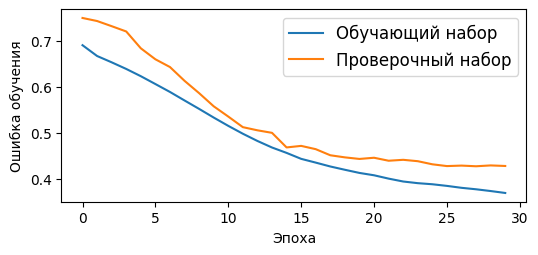

Acc =  0.7825106489601603


Epoch 1: 100%|██████████| 132/132 [00:06<00:00, 18.86it/s]


2023-06-03 09:56:24.577058 Epoch 1, Train loss 0.687, Val loss 0.748, Acc_val = 0.43


Epoch 2: 100%|██████████| 132/132 [00:06<00:00, 18.88it/s]


2023-06-03 09:56:31.761761 Epoch 2, Train loss 0.655, Val loss 0.749, Acc_val = 0.35


Epoch 3: 100%|██████████| 132/132 [00:07<00:00, 18.56it/s]


2023-06-03 09:56:39.067423 Epoch 3, Train loss 0.637, Val loss 0.775, Acc_val = 0.47


Epoch 4: 100%|██████████| 132/132 [00:07<00:00, 18.83it/s]


2023-06-03 09:56:46.272119 Epoch 4, Train loss 0.620, Val loss 0.766, Acc_val = 0.53


Epoch 5: 100%|██████████| 132/132 [00:07<00:00, 18.62it/s]


2023-06-03 09:56:53.540794 Epoch 5, Train loss 0.603, Val loss 0.742, Acc_val = 0.56


Epoch 6: 100%|██████████| 132/132 [00:07<00:00, 18.73it/s]


2023-06-03 09:57:00.772481 Epoch 6, Train loss 0.591, Val loss 0.731, Acc_val = 0.58


Epoch 7: 100%|██████████| 132/132 [00:07<00:00, 17.82it/s]


2023-06-03 09:57:08.360054 Epoch 7, Train loss 0.576, Val loss 0.699, Acc_val = 0.58


Epoch 8: 100%|██████████| 132/132 [00:07<00:00, 18.17it/s]


2023-06-03 09:57:15.815670 Epoch 8, Train loss 0.567, Val loss 0.705, Acc_val = 0.64


Epoch 9: 100%|██████████| 132/132 [00:07<00:00, 18.72it/s]


2023-06-03 09:57:23.054354 Epoch 9, Train loss 0.556, Val loss 0.679, Acc_val = 0.65


Epoch 10: 100%|██████████| 132/132 [00:07<00:00, 18.56it/s]


2023-06-03 09:57:30.357019 Epoch 10, Train loss 0.547, Val loss 0.678, Acc_val = 0.68


Epoch 11: 100%|██████████| 132/132 [00:07<00:00, 18.58it/s]


2023-06-03 09:57:37.650685 Epoch 11, Train loss 0.537, Val loss 0.666, Acc_val = 0.68


Epoch 12: 100%|██████████| 132/132 [00:07<00:00, 18.55it/s]


2023-06-03 09:57:44.965346 Epoch 12, Train loss 0.528, Val loss 0.648, Acc_val = 0.69


Epoch 13: 100%|██████████| 132/132 [00:06<00:00, 18.89it/s]


2023-06-03 09:57:52.141051 Epoch 13, Train loss 0.517, Val loss 0.635, Acc_val = 0.69


Epoch 14: 100%|██████████| 132/132 [00:07<00:00, 18.78it/s]


2023-06-03 09:57:59.361742 Epoch 14, Train loss 0.512, Val loss 0.609, Acc_val = 0.69


Epoch 15: 100%|██████████| 132/132 [00:06<00:00, 18.93it/s]


2023-06-03 09:58:06.522451 Epoch 15, Train loss 0.503, Val loss 0.651, Acc_val = 0.69


Epoch 16: 100%|██████████| 132/132 [00:07<00:00, 18.68it/s]


2023-06-03 09:58:13.785128 Epoch 16, Train loss 0.491, Val loss 0.642, Acc_val = 0.69


Epoch 17: 100%|██████████| 132/132 [00:07<00:00, 18.50it/s]


2023-06-03 09:58:21.105786 Epoch 17, Train loss 0.482, Val loss 0.638, Acc_val = 0.69


Epoch 18: 100%|██████████| 132/132 [00:07<00:00, 18.83it/s]


2023-06-03 09:58:28.307483 Epoch 18, Train loss 0.478, Val loss 0.627, Acc_val = 0.69


Epoch 19: 100%|██████████| 132/132 [00:07<00:00, 18.83it/s]


2023-06-03 09:58:35.507180 Epoch 19, Train loss 0.468, Val loss 0.651, Acc_val = 0.57


Epoch 20: 100%|██████████| 132/132 [00:06<00:00, 18.92it/s]


2023-06-03 09:58:42.678887 Epoch 20, Train loss 0.457, Val loss 0.623, Acc_val = 0.68


Epoch 21: 100%|██████████| 132/132 [00:07<00:00, 18.75it/s]


2023-06-03 09:58:49.903575 Epoch 21, Train loss 0.447, Val loss 0.616, Acc_val = 0.68


Epoch 22: 100%|██████████| 132/132 [00:07<00:00, 18.67it/s]


2023-06-03 09:58:57.164253 Epoch 22, Train loss 0.438, Val loss 0.654, Acc_val = 0.52


Epoch 23: 100%|██████████| 132/132 [00:07<00:00, 18.32it/s]


2023-06-03 09:59:04.564886 Epoch 23, Train loss 0.428, Val loss 0.639, Acc_val = 0.54


Epoch 24: 100%|██████████| 132/132 [00:06<00:00, 18.88it/s]


2023-06-03 09:59:11.745591 Epoch 24, Train loss 0.423, Val loss 0.643, Acc_val = 0.53


Epoch 25: 100%|██████████| 132/132 [00:06<00:00, 18.98it/s]


2023-06-03 09:59:18.889305 Epoch 25, Train loss 0.416, Val loss 0.659, Acc_val = 0.39


Epoch 26: 100%|██████████| 132/132 [00:07<00:00, 18.72it/s]


2023-06-03 09:59:26.126990 Epoch 26, Train loss 0.411, Val loss 0.651, Acc_val = 0.42


Epoch 27: 100%|██████████| 132/132 [00:06<00:00, 19.03it/s]


2023-06-03 09:59:33.262708 Epoch 27, Train loss 0.399, Val loss 0.676, Acc_val = 0.38


Epoch 28: 100%|██████████| 132/132 [00:07<00:00, 18.68it/s]


2023-06-03 09:59:40.527384 Epoch 28, Train loss 0.395, Val loss 0.681, Acc_val = 0.38


Epoch 29: 100%|██████████| 132/132 [00:06<00:00, 18.92it/s]


2023-06-03 09:59:47.691092 Epoch 29, Train loss 0.388, Val loss 0.680, Acc_val = 0.38


Epoch 30: 100%|██████████| 132/132 [00:06<00:00, 18.88it/s]


2023-06-03 09:59:54.872795 Epoch 30, Train loss 0.381, Val loss 0.710, Acc_val = 0.38


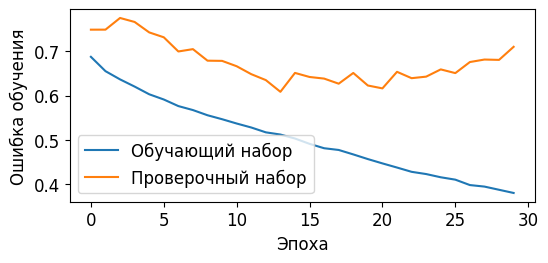

Acc =  0.8184826282202788


Epoch 1: 100%|██████████| 127/127 [00:06<00:00, 18.96it/s]


2023-06-03 10:00:10.392831 Epoch 1, Train loss 0.694, Val loss 0.689, Acc_val = 0.40


Epoch 2: 100%|██████████| 127/127 [00:06<00:00, 18.62it/s]


2023-06-03 10:00:17.459571 Epoch 2, Train loss 0.656, Val loss 0.687, Acc_val = 0.54


Epoch 3: 100%|██████████| 127/127 [00:06<00:00, 18.50it/s]


2023-06-03 10:00:24.572296 Epoch 3, Train loss 0.634, Val loss 0.698, Acc_val = 0.72


Epoch 4: 100%|██████████| 127/127 [00:06<00:00, 18.43it/s]


2023-06-03 10:00:31.714012 Epoch 4, Train loss 0.610, Val loss 0.699, Acc_val = 0.79


Epoch 5: 100%|██████████| 127/127 [00:06<00:00, 18.80it/s]


2023-06-03 10:00:38.774753 Epoch 5, Train loss 0.588, Val loss 0.701, Acc_val = 0.76


Epoch 6: 100%|██████████| 127/127 [00:06<00:00, 18.69it/s]


2023-06-03 10:00:45.822499 Epoch 6, Train loss 0.565, Val loss 0.698, Acc_val = 0.74


Epoch 7: 100%|██████████| 127/127 [00:06<00:00, 18.38it/s]


2023-06-03 10:00:52.971212 Epoch 7, Train loss 0.545, Val loss 0.690, Acc_val = 0.69


Epoch 8: 100%|██████████| 127/127 [00:06<00:00, 18.55it/s]


2023-06-03 10:01:00.077940 Epoch 8, Train loss 0.529, Val loss 0.679, Acc_val = 0.67


Epoch 9: 100%|██████████| 127/127 [00:06<00:00, 18.52it/s]


2023-06-03 10:01:07.178669 Epoch 9, Train loss 0.510, Val loss 0.668, Acc_val = 0.76


Epoch 10: 100%|██████████| 127/127 [00:06<00:00, 18.76it/s]


2023-06-03 10:01:14.199423 Epoch 10, Train loss 0.494, Val loss 0.652, Acc_val = 0.75


Epoch 11: 100%|██████████| 127/127 [00:06<00:00, 18.45it/s]


2023-06-03 10:01:21.325144 Epoch 11, Train loss 0.478, Val loss 0.632, Acc_val = 0.76


Epoch 12: 100%|██████████| 127/127 [00:06<00:00, 18.66it/s]


2023-06-03 10:01:28.379887 Epoch 12, Train loss 0.463, Val loss 0.617, Acc_val = 0.80


Epoch 13: 100%|██████████| 127/127 [00:06<00:00, 18.55it/s]


2023-06-03 10:01:35.495613 Epoch 13, Train loss 0.450, Val loss 0.601, Acc_val = 0.80


Epoch 14: 100%|██████████| 127/127 [00:06<00:00, 18.75it/s]


2023-06-03 10:01:42.509368 Epoch 14, Train loss 0.437, Val loss 0.583, Acc_val = 0.80


Epoch 15: 100%|██████████| 127/127 [00:06<00:00, 18.69it/s]


2023-06-03 10:01:49.546118 Epoch 15, Train loss 0.426, Val loss 0.574, Acc_val = 0.82


Epoch 16: 100%|██████████| 127/127 [00:06<00:00, 18.90it/s]


2023-06-03 10:01:56.500894 Epoch 16, Train loss 0.416, Val loss 0.555, Acc_val = 0.81


Epoch 17: 100%|██████████| 127/127 [00:06<00:00, 18.59it/s]


2023-06-03 10:02:03.575630 Epoch 17, Train loss 0.405, Val loss 0.543, Acc_val = 0.82


Epoch 18: 100%|██████████| 127/127 [00:06<00:00, 18.77it/s]


2023-06-03 10:02:10.637371 Epoch 18, Train loss 0.394, Val loss 0.532, Acc_val = 0.82


Epoch 19: 100%|██████████| 127/127 [00:06<00:00, 18.78it/s]


2023-06-03 10:02:17.666123 Epoch 19, Train loss 0.385, Val loss 0.520, Acc_val = 0.82


Epoch 20: 100%|██████████| 127/127 [00:06<00:00, 18.72it/s]


2023-06-03 10:02:24.688877 Epoch 20, Train loss 0.379, Val loss 0.510, Acc_val = 0.83


Epoch 21: 100%|██████████| 127/127 [00:06<00:00, 18.93it/s]


2023-06-03 10:02:31.643653 Epoch 21, Train loss 0.372, Val loss 0.506, Acc_val = 0.83


Epoch 22: 100%|██████████| 127/127 [00:06<00:00, 18.67it/s]


2023-06-03 10:02:38.698396 Epoch 22, Train loss 0.366, Val loss 0.493, Acc_val = 0.83


Epoch 23: 100%|██████████| 127/127 [00:06<00:00, 18.83it/s]


2023-06-03 10:02:45.690160 Epoch 23, Train loss 0.360, Val loss 0.488, Acc_val = 0.84


Epoch 24: 100%|██████████| 127/127 [00:06<00:00, 18.66it/s]


2023-06-03 10:02:52.748902 Epoch 24, Train loss 0.355, Val loss 0.479, Acc_val = 0.83


Epoch 25: 100%|██████████| 127/127 [00:06<00:00, 18.78it/s]


2023-06-03 10:02:59.752662 Epoch 25, Train loss 0.351, Val loss 0.479, Acc_val = 0.84


Epoch 26: 100%|██████████| 127/127 [00:06<00:00, 18.65it/s]


2023-06-03 10:03:06.800408 Epoch 26, Train loss 0.345, Val loss 0.473, Acc_val = 0.84


Epoch 27: 100%|██████████| 127/127 [00:06<00:00, 19.14it/s]


2023-06-03 10:03:13.670210 Epoch 27, Train loss 0.341, Val loss 0.467, Acc_val = 0.84


Epoch 28: 100%|██████████| 127/127 [00:06<00:00, 18.90it/s]


2023-06-03 10:03:20.630984 Epoch 28, Train loss 0.337, Val loss 0.471, Acc_val = 0.85


Epoch 29: 100%|██████████| 127/127 [00:06<00:00, 18.94it/s]


2023-06-03 10:03:27.578762 Epoch 29, Train loss 0.334, Val loss 0.466, Acc_val = 0.85


Epoch 30: 100%|██████████| 127/127 [00:06<00:00, 19.13it/s]


2023-06-03 10:03:34.461560 Epoch 30, Train loss 0.331, Val loss 0.461, Acc_val = 0.85


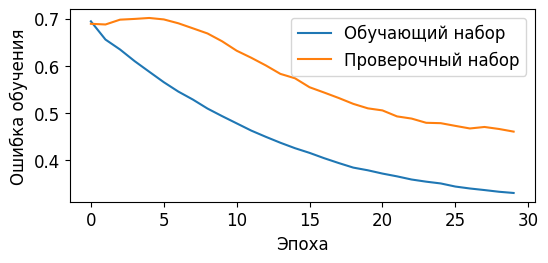

Acc =  0.6226979742173112


Epoch 1: 100%|██████████| 137/137 [00:08<00:00, 16.50it/s]


2023-06-03 10:03:51.835004 Epoch 1, Train loss 0.699, Val loss 0.697, Acc_val = 0.52


Epoch 2: 100%|██████████| 137/137 [00:07<00:00, 18.13it/s]


2023-06-03 10:03:59.592522 Epoch 2, Train loss 0.671, Val loss 0.663, Acc_val = 0.73


Epoch 3: 100%|██████████| 137/137 [00:07<00:00, 18.11it/s]


2023-06-03 10:04:07.386029 Epoch 3, Train loss 0.648, Val loss 0.633, Acc_val = 0.77


Epoch 4: 100%|██████████| 137/137 [00:07<00:00, 18.48it/s]


2023-06-03 10:04:15.015589 Epoch 4, Train loss 0.625, Val loss 0.599, Acc_val = 0.80


Epoch 5: 100%|██████████| 137/137 [00:07<00:00, 17.89it/s]


2023-06-03 10:04:22.895069 Epoch 5, Train loss 0.601, Val loss 0.559, Acc_val = 0.99


Epoch 6: 100%|██████████| 137/137 [00:07<00:00, 18.48it/s]


2023-06-03 10:04:30.510634 Epoch 6, Train loss 0.578, Val loss 0.530, Acc_val = 0.99


Epoch 7: 100%|██████████| 137/137 [00:07<00:00, 18.80it/s]


2023-06-03 10:04:38.004236 Epoch 7, Train loss 0.558, Val loss 0.500, Acc_val = 0.99


Epoch 8: 100%|██████████| 137/137 [00:07<00:00, 18.50it/s]


2023-06-03 10:04:45.610804 Epoch 8, Train loss 0.538, Val loss 0.469, Acc_val = 0.99


Epoch 9: 100%|██████████| 137/137 [00:07<00:00, 18.55it/s]


2023-06-03 10:04:53.265355 Epoch 9, Train loss 0.518, Val loss 0.444, Acc_val = 0.98


Epoch 10: 100%|██████████| 137/137 [00:07<00:00, 18.37it/s]


2023-06-03 10:05:00.933902 Epoch 10, Train loss 0.500, Val loss 0.415, Acc_val = 0.99


Epoch 11: 100%|██████████| 137/137 [00:07<00:00, 17.35it/s]


2023-06-03 10:05:09.044309 Epoch 11, Train loss 0.480, Val loss 0.393, Acc_val = 0.97


Epoch 12: 100%|██████████| 137/137 [00:07<00:00, 19.49it/s]


2023-06-03 10:05:16.268997 Epoch 12, Train loss 0.462, Val loss 0.364, Acc_val = 0.99


Epoch 13: 100%|██████████| 137/137 [00:06<00:00, 19.59it/s]


2023-06-03 10:05:23.455699 Epoch 13, Train loss 0.447, Val loss 0.346, Acc_val = 0.95


Epoch 14: 100%|██████████| 137/137 [00:07<00:00, 19.21it/s]


2023-06-03 10:05:30.779356 Epoch 14, Train loss 0.431, Val loss 0.326, Acc_val = 0.96


Epoch 15: 100%|██████████| 137/137 [00:07<00:00, 17.79it/s]


2023-06-03 10:05:38.687827 Epoch 15, Train loss 0.415, Val loss 0.302, Acc_val = 1.00


Epoch 16: 100%|██████████| 137/137 [00:07<00:00, 17.90it/s]


2023-06-03 10:05:46.578258 Epoch 16, Train loss 0.402, Val loss 0.289, Acc_val = 1.00


Epoch 17: 100%|██████████| 137/137 [00:08<00:00, 15.23it/s]


2023-06-03 10:05:55.856001 Epoch 17, Train loss 0.388, Val loss 0.273, Acc_val = 1.00


Epoch 18: 100%|██████████| 137/137 [00:08<00:00, 15.62it/s]


2023-06-03 10:06:04.848847 Epoch 18, Train loss 0.377, Val loss 0.259, Acc_val = 1.00


Epoch 19: 100%|██████████| 137/137 [00:08<00:00, 16.75it/s]


2023-06-03 10:06:13.270843 Epoch 19, Train loss 0.366, Val loss 0.251, Acc_val = 1.00


Epoch 20: 100%|██████████| 137/137 [00:09<00:00, 15.14it/s]


2023-06-03 10:06:22.559860 Epoch 20, Train loss 0.356, Val loss 0.242, Acc_val = 1.00


Epoch 21: 100%|██████████| 137/137 [00:08<00:00, 16.59it/s]


2023-06-03 10:06:31.023978 Epoch 21, Train loss 0.345, Val loss 0.233, Acc_val = 1.00


Epoch 22: 100%|██████████| 137/137 [00:07<00:00, 17.28it/s]


2023-06-03 10:06:39.188368 Epoch 22, Train loss 0.335, Val loss 0.227, Acc_val = 1.00


Epoch 23: 100%|██████████| 137/137 [00:07<00:00, 17.17it/s]


2023-06-03 10:06:47.398740 Epoch 23, Train loss 0.326, Val loss 0.216, Acc_val = 1.00


Epoch 24: 100%|██████████| 137/137 [00:09<00:00, 14.91it/s]


2023-06-03 10:06:56.806731 Epoch 24, Train loss 0.320, Val loss 0.215, Acc_val = 1.00


Epoch 25: 100%|██████████| 137/137 [00:07<00:00, 17.83it/s]


2023-06-03 10:07:04.711204 Epoch 25, Train loss 0.310, Val loss 0.203, Acc_val = 1.00


Epoch 26: 100%|██████████| 137/137 [00:08<00:00, 16.72it/s]


2023-06-03 10:07:13.108517 Epoch 26, Train loss 0.306, Val loss 0.207, Acc_val = 1.00


Epoch 27: 100%|██████████| 137/137 [00:07<00:00, 18.29it/s]


2023-06-03 10:07:20.800211 Epoch 27, Train loss 0.298, Val loss 0.198, Acc_val = 1.00


Epoch 28: 100%|██████████| 137/137 [00:07<00:00, 18.63it/s]


2023-06-03 10:07:28.369904 Epoch 28, Train loss 0.291, Val loss 0.195, Acc_val = 1.00


Epoch 29: 100%|██████████| 137/137 [00:06<00:00, 19.70it/s]


2023-06-03 10:07:35.512871 Epoch 29, Train loss 0.287, Val loss 0.192, Acc_val = 1.00


Epoch 30: 100%|██████████| 137/137 [00:08<00:00, 16.00it/s]


2023-06-03 10:07:44.267697 Epoch 30, Train loss 0.280, Val loss 0.195, Acc_val = 1.00


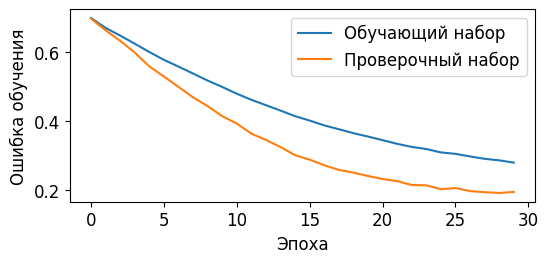

Acc =  0.7260158013544018


Epoch 1: 100%|██████████| 125/125 [00:06<00:00, 20.04it/s]


2023-06-03 10:07:57.893484 Epoch 1, Train loss 0.701, Val loss 0.651, Acc_val = 0.58


Epoch 2: 100%|██████████| 125/125 [00:06<00:00, 18.14it/s]


2023-06-03 10:08:05.152256 Epoch 2, Train loss 0.675, Val loss 0.639, Acc_val = 0.70


Epoch 3: 100%|██████████| 125/125 [00:06<00:00, 18.55it/s]


2023-06-03 10:08:12.259213 Epoch 3, Train loss 0.659, Val loss 0.629, Acc_val = 0.85


Epoch 4: 100%|██████████| 125/125 [00:06<00:00, 19.79it/s]


2023-06-03 10:08:18.891413 Epoch 4, Train loss 0.645, Val loss 0.625, Acc_val = 0.85


Epoch 5: 100%|██████████| 125/125 [00:06<00:00, 19.30it/s]


2023-06-03 10:08:25.759148 Epoch 5, Train loss 0.628, Val loss 0.607, Acc_val = 0.84


Epoch 6: 100%|██████████| 125/125 [00:06<00:00, 19.80it/s]


2023-06-03 10:08:32.423205 Epoch 6, Train loss 0.614, Val loss 0.588, Acc_val = 0.84


Epoch 7: 100%|██████████| 125/125 [00:06<00:00, 18.86it/s]


2023-06-03 10:08:39.385253 Epoch 7, Train loss 0.602, Val loss 0.571, Acc_val = 0.86


Epoch 8: 100%|██████████| 125/125 [00:06<00:00, 20.19it/s]


2023-06-03 10:08:45.895191 Epoch 8, Train loss 0.589, Val loss 0.556, Acc_val = 0.86


Epoch 9: 100%|██████████| 125/125 [00:07<00:00, 17.60it/s]


2023-06-03 10:08:53.332597 Epoch 9, Train loss 0.577, Val loss 0.543, Acc_val = 0.87


Epoch 10: 100%|██████████| 125/125 [00:06<00:00, 19.07it/s]


2023-06-03 10:09:00.237333 Epoch 10, Train loss 0.565, Val loss 0.544, Acc_val = 0.86


Epoch 11: 100%|██████████| 125/125 [00:06<00:00, 18.44it/s]


2023-06-03 10:09:07.402778 Epoch 11, Train loss 0.552, Val loss 0.534, Acc_val = 0.86


Epoch 12: 100%|██████████| 125/125 [00:06<00:00, 18.97it/s]


2023-06-03 10:09:14.319781 Epoch 12, Train loss 0.539, Val loss 0.517, Acc_val = 0.86


Epoch 13: 100%|██████████| 125/125 [00:06<00:00, 20.25it/s]


2023-06-03 10:09:20.825265 Epoch 13, Train loss 0.528, Val loss 0.512, Acc_val = 0.86


Epoch 14: 100%|██████████| 125/125 [00:06<00:00, 19.59it/s]


2023-06-03 10:09:27.539271 Epoch 14, Train loss 0.515, Val loss 0.502, Acc_val = 0.86


Epoch 15: 100%|██████████| 125/125 [00:07<00:00, 17.80it/s]


2023-06-03 10:09:35.128190 Epoch 15, Train loss 0.504, Val loss 0.486, Acc_val = 0.89


Epoch 16: 100%|██████████| 125/125 [00:07<00:00, 17.62it/s]


2023-06-03 10:09:42.620791 Epoch 16, Train loss 0.495, Val loss 0.488, Acc_val = 0.86


Epoch 17: 100%|██████████| 125/125 [00:07<00:00, 15.68it/s]


2023-06-03 10:09:51.034100 Epoch 17, Train loss 0.482, Val loss 0.493, Acc_val = 0.86


Epoch 18: 100%|██████████| 125/125 [00:07<00:00, 17.56it/s]


2023-06-03 10:09:58.503711 Epoch 18, Train loss 0.473, Val loss 0.473, Acc_val = 0.89


Epoch 19: 100%|██████████| 125/125 [00:07<00:00, 17.44it/s]


2023-06-03 10:10:06.028305 Epoch 19, Train loss 0.464, Val loss 0.461, Acc_val = 0.91


Epoch 20: 100%|██████████| 125/125 [00:06<00:00, 17.98it/s]


2023-06-03 10:10:13.328969 Epoch 20, Train loss 0.457, Val loss 0.454, Acc_val = 0.91


Epoch 21: 100%|██████████| 125/125 [00:06<00:00, 18.38it/s]


2023-06-03 10:10:20.486680 Epoch 21, Train loss 0.450, Val loss 0.449, Acc_val = 0.92


Epoch 22: 100%|██████████| 125/125 [00:06<00:00, 18.13it/s]


2023-06-03 10:10:27.725365 Epoch 22, Train loss 0.443, Val loss 0.449, Acc_val = 0.91


Epoch 23: 100%|██████████| 125/125 [00:06<00:00, 18.20it/s]


2023-06-03 10:10:34.948054 Epoch 23, Train loss 0.436, Val loss 0.443, Acc_val = 0.91


Epoch 24: 100%|██████████| 125/125 [00:06<00:00, 18.22it/s]


2023-06-03 10:10:42.168746 Epoch 24, Train loss 0.429, Val loss 0.438, Acc_val = 0.91


Epoch 25: 100%|██████████| 125/125 [00:06<00:00, 18.15it/s]


2023-06-03 10:10:49.405430 Epoch 25, Train loss 0.425, Val loss 0.434, Acc_val = 0.91


Epoch 26: 100%|██████████| 125/125 [00:06<00:00, 17.95it/s]


2023-06-03 10:10:56.730171 Epoch 26, Train loss 0.419, Val loss 0.434, Acc_val = 0.91


Epoch 27: 100%|██████████| 125/125 [00:06<00:00, 18.66it/s]


2023-06-03 10:11:03.763199 Epoch 27, Train loss 0.416, Val loss 0.425, Acc_val = 0.92


Epoch 28: 100%|██████████| 125/125 [00:06<00:00, 20.05it/s]


2023-06-03 10:11:10.327766 Epoch 28, Train loss 0.408, Val loss 0.424, Acc_val = 0.91


Epoch 29: 100%|██████████| 125/125 [00:07<00:00, 16.93it/s]


2023-06-03 10:11:18.074325 Epoch 29, Train loss 0.405, Val loss 0.413, Acc_val = 0.93


Epoch 30: 100%|██████████| 125/125 [00:07<00:00, 17.55it/s]


2023-06-03 10:11:25.569927 Epoch 30, Train loss 0.403, Val loss 0.418, Acc_val = 0.91


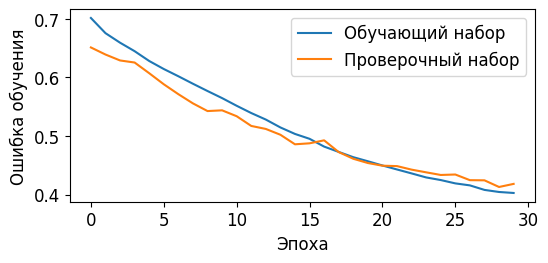

Acc =  0.8839285714285714
Final results
30 epochs. Acc_sk = 0.76 (Sens = 0.77 / Spec = 0.75) 0.78 / 0.82 / 0.62 / 0.73 / 0.88


C:\Users\Tanya\AppData\Local\Temp\ipykernel_2100\1709305254.py:97: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,len(folds),i+1)


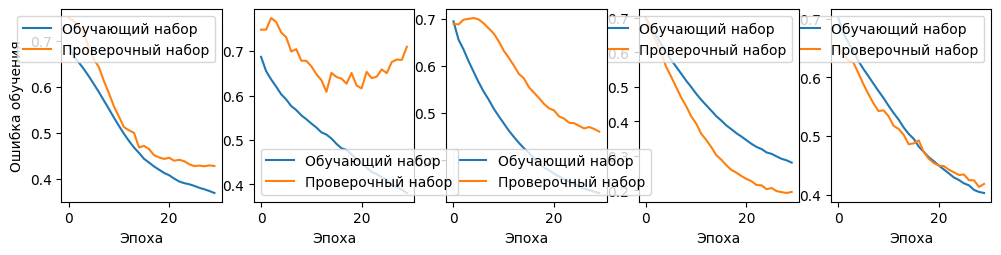

In [18]:
import os
model_dir = 'model_backup'
if not os.path.exists(model_dir):  
  os.makedirs(model_dir)

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN1()

# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.9) # 40 epochs. Acc_sk = 0.70 (Sens = 0.74 / Spec = 0.66) 0.68 / 0.86 / 0.52 / 0.76 / 0.77
# self.layer1_filt = 2 (before 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.9) # 15 epochs. Acc_sk = 0.66 (Sens = 0.62 / Spec = 0.70) 0.68 / 0.55 / 0.57 / 0.62 / 0.88
# max_pool_width = 4 (before 1)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.9) # 15 epochs. Acc_sk = 0.59 (Sens = 0.53 / Spec = 0.65) 0.65 / 0.50 / 0.56 / 0.61 / 0.63
# self.layer1_filt = 4 + max_pool_width = 4 + lf1_height, lf1_width = 29,43
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.65 (Sens = 0.61 / Spec = 0.69) 0.61 / 0.62 / 0.60 / 0.65 / 0.75 (good behaviour)
# mf2_height,mf2_width = 15,43 (before 15x17)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.72 (Sens = 0.73 / Spec = 0.70) 0.71 / 0.69 / 0.53 / 0.75 / 0.90
# hf4_height,hf4_width = 15,43 (before 15x15)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.70 (Sens = 0.76 / Spec = 0.64) 0.73 / 0.66 / 0.53 / 0.73 / 0.86
# hf4_height,hf4_width = 15,31 (before 15x43)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.71 (Sens = 0.77 / Spec = 0.64) 0.67 / 0.79 / 0.51 / 0.68 / 0.89
# hf3_height,hf3_width = 13,27 (before 11x11)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.76 (Sens = 0.81 / Spec = 0.70) 0.78 / 0.86 / 0.53 / 0.74 / 0.89
# mf_height,mf_width = 13,27 (before 3x3)
optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.76 (Sens = 0.77 / Spec = 0.75) 0.78 / 0.82 / 0.62 / 0.73 / 0.88

k_fold_CV(dataset=DataSet_ALS, model = model, optimizer=optimizer, train = training_loop, n_epochs=30)

In [60]:
# Test 1
test_img = torch.rand(64,86)
test_img_row = test_img.view(-1,64*86)
print(test_img.shape)
print(test_img_row.shape)

# Test 2
test_img = torch.rand(1,10)
test_img_row = test_img.squeeze()
print(test_img.shape)
print(test_img_row.shape)

#Test 3
# print(torch.sigmoid(torch.tensor(-1)), torch.sigmoid(torch.tensor(0)), torch.sigmoid(torch.tensor(1)))

#Test 4
# x = torch.randn(3)
# x3 = torch.cat((x, x, x), 0)
# print(x3)

#Test 5
A = np.random.random((2,3))
print(A.shape)
A = A.reshape((1,A.shape[0],A.shape[1]))
print(A.shape)

torch.Size([64, 86])
torch.Size([1, 5504])
torch.Size([1, 10])
torch.Size([10])
(2, 3)
(1, 2, 3)


### CV-Fold selection

In [2]:
file_name =  'HC_ALS_table.xlsx' # path to file + file name

xls_file = pd.ExcelFile(file_name)
# print(xls_file.sheet_names)

# https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values

df_HC = xls_file.parse('Control')
df_ALS = xls_file.parse('ALS')
# print(df_HC['fold']==1)
for fold_num in range(1,6):
    HC_fold = df_HC.loc[df_HC['fold']==fold_num]
    ALS_fold = df_ALS.loc[df_ALS['fold']==fold_num]
    # print(HC_fold)
    # print(ALS_fold)
    print(np.hstack((HC_fold['Subject code'].to_numpy(), ALS_fold['Subject code'].to_numpy())))
    HC_age = (float)(HC_fold.loc[:, 'Age'].mean())
    HC_m = (HC_fold.loc[HC_fold['Sex']=='m'])
    HC_f = (HC_fold.loc[HC_fold['Sex']=='f'])
    ALS_age = (float)(ALS_fold.loc[:, 'Age'].mean())
    ALS_m = (ALS_fold.loc[ALS_fold['Sex']=='m'])
    ALS_f = (ALS_fold.loc[ALS_fold['Sex']=='f'])
    print(f'Fold {fold_num} HC age mean = {HC_age:.2f}, mens = {len(HC_m.index)}, womens = {len(HC_f.index)}')
    print(f'Fold {fold_num} ALS age mean = {ALS_age:.2f}, mens = {len(ALS_m.index)}, womens = {len(ALS_f.index)}')

[ 26  97 117  85  53  86 127  92 102  27  32  72  39]
Fold 1 HC age mean = 52.43, mens = 3, womens = 4
Fold 1 ALS age mean = 56.83, mens = 3, womens = 3
[ 28 123  63  99  81 125 129  68  21  55  48  78  42]
Fold 2 HC age mean = 53.71, mens = 3, womens = 4
Fold 2 ALS age mean = 58.33, mens = 4, womens = 2
[ 61  16 115 109 111   2 107  46  84  64  52  24  76]
Fold 3 HC age mean = 55.43, mens = 2, womens = 5
Fold 3 ALS age mean = 59.67, mens = 4, womens = 2
[ 77   6  65  24 131 119  25  94  62  28   8  98  22]
Fold 4 HC age mean = 53.00, mens = 3, womens = 3
Fold 4 ALS age mean = 60.86, mens = 5, womens = 2
[ 49  89   4  42 113 121  96  20  58  80  31 100]
Fold 5 HC age mean = 54.17, mens = 2, womens = 4
Fold 5 ALS age mean = 61.00, mens = 4, womens = 2
